In [2]:
import os
signal_list=[]
for filename in os.listdir("SMC_WatchSpO2_deliverable_241226/SMC_WatchSpO2_deliverable_241226"):
    print(filename)

.DS_Store
watch4
watch5
watch6
watch7


In [3]:

directory="SMC_WatchSpO2_deliverable_241226/SMC_WatchSpO2_deliverable_241226"

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df_dict = {}
device_names = ['GW4','GW5','GW6','GW7']
for device_name in device_names:
    path = os.path.join(directory, 'watch' + device_name[-1])
    GW = os.listdir(path)
    GW.sort()
    for file_name in GW:
        file_path = os.path.join(path, file_name)
        df = pd.read_csv(file_path)
        if device_name == 'GW4':
            try:
                patient = 'GW4' + file_name.split('SUB_SMC_')[1].split('_')[0]
            except Exception:
                continue
        else:
            try:
                patient_id = file_name.split('_Id')[1].split('_')[0]
                patient = 'GW' + device_name[-1] + patient_id[-3:]
            except Exception:
                continue
        signal = df['SpO2'].values
        zero_count = np.sum(signal == 0)
        if patient not in df_dict or zero_count < df_dict[patient][1]:
            df_dict[patient] = (signal, zero_count)
df_list = [(signal, patient) for patient, (signal, _) in df_dict.items()]
print(f"length of df_list {len(df_list)}")

length of df_list 390


In [6]:
new_df_list = []
for signal, patient in df_list:
    signal_length = len(signal)
    num_segments = signal_length // 1000
    for i in range(num_segments):
        start_idx = i * 1000
        end_idx = start_idx + 1000
        segment = signal[start_idx:end_idx]
        new_df_list.append((segment, f"{patient}_seg{i}"))

print(len(new_df_list))

9709


Original signals: 9709
After filtering (<=50% zeros): 9485


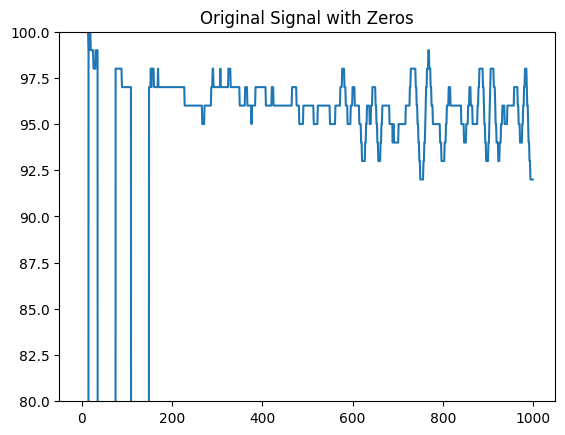

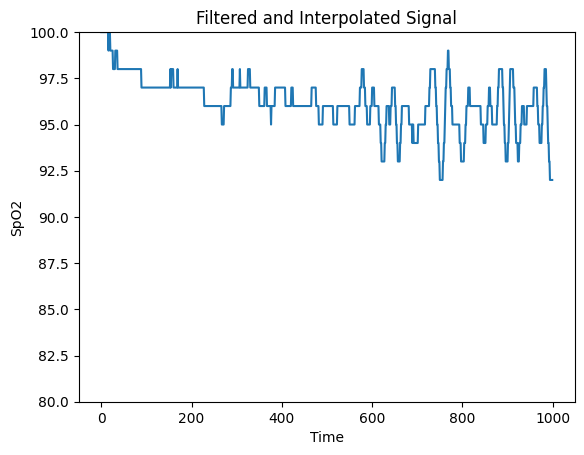

In [19]:
signals_only = [signal for signal, patient in new_df_list]

filtered_signals_only = []
for signal in signals_only:
    zero_count = np.sum(signal == 0)
    zero_percentage = zero_count / len(signal)
    if zero_percentage <= 0.5:
        filtered_signals_only.append(signal)

print(f"Original signals: {len(signals_only)}")
print(f"After filtering (<=50% zeros): {len(filtered_signals_only)}")

plt.plot(filtered_signals_only[0])
plt.title('Original Signal with Zeros')
plt.ylim(80,100)
plt.show()

def filter_and_interpolate(signal):
    result = signal.copy()
    zero_indices = np.where(signal == 0)[0]
    
    for idx in zero_indices:
        left_val = None
        right_val = None
        
        # Find nearest non-zero value to the left
        for i in range(idx-1, -1, -1):
            if signal[i] != 0:
                left_val = signal[i]
                left_idx = i
                break
        
        # Find nearest non-zero value to the right
        for i in range(idx+1, len(signal)):
            if signal[i] != 0:
                right_val = signal[i]
                right_idx = i
                break
        
        # Interpolate
        if left_val is not None and right_val is not None:
            # Linear interpolation
            weight = (idx - left_idx) / (right_idx - left_idx)
            result[idx] = left_val + weight * (right_val - left_val)
        elif left_val is not None:
            result[idx] = left_val
        elif right_val is not None:
            result[idx] = right_val
    
    return result

# Apply filtering and interpolation
signals = [filter_and_interpolate(signal) for signal in filtered_signals_only]
plt.plot(signals[0])
plt.title('Filtered and Interpolated Signal')
plt.xlabel('Time')
plt.ylabel('SpO2')
plt.ylim(80,100)
plt.show()

Minimum signal length: 1000
Prepared 9485 signals of length 1000 for SSL training


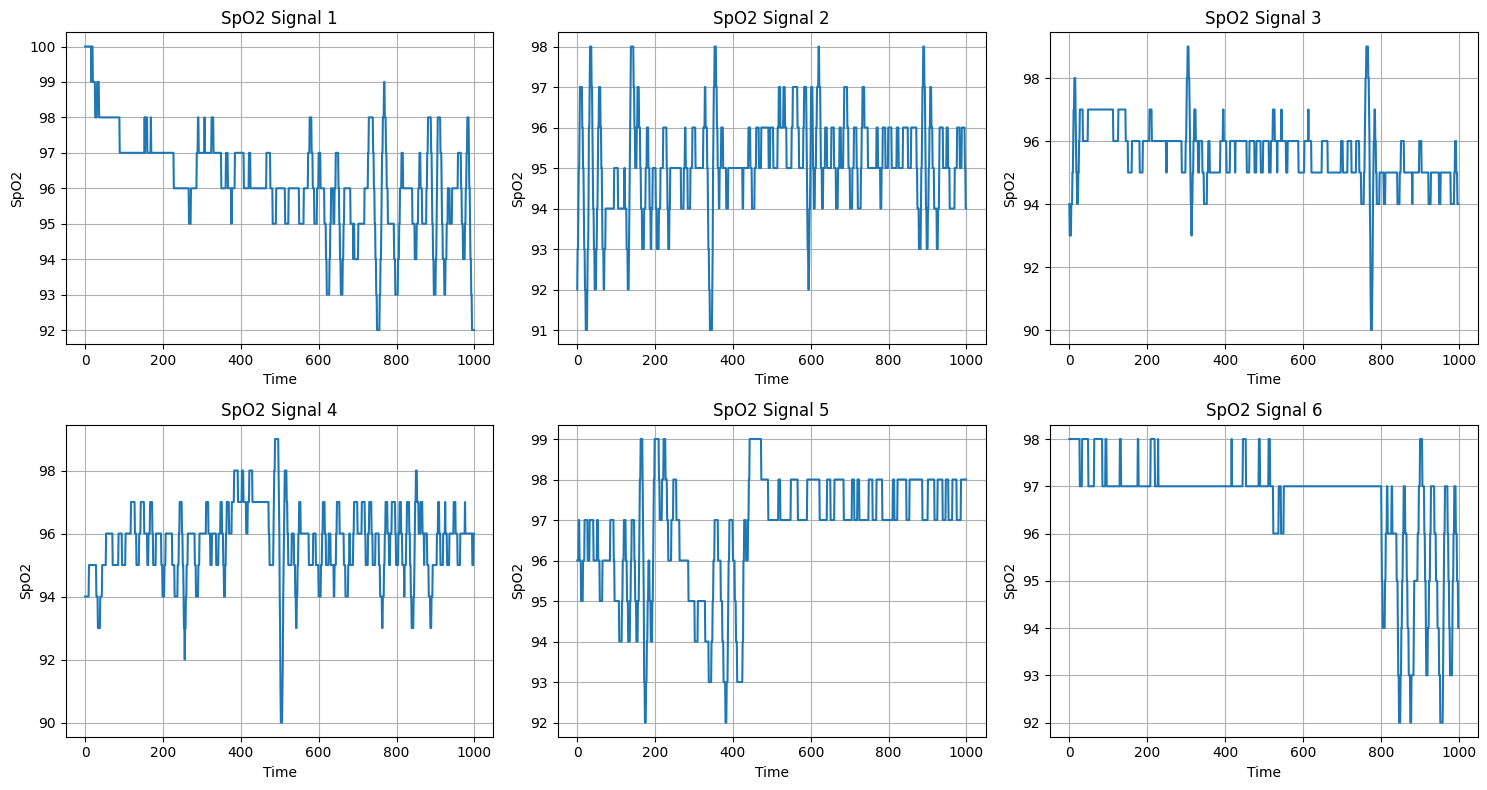

In [20]:


# Find minimum length across all signals
min_length = min(len(signal) for signal in signals)
print(f"Minimum signal length: {min_length}")

# Truncate all signals to minimum length
truncated_signals = []
for signal in signals:
    truncated = signal[:min_length]
    # Reshape to (1, length) for 1D time series
    truncated_signals.append(truncated.reshape(1, -1))


print(f"Prepared {len(truncated_signals)} signals of length {min_length} for SSL training")

# Visualize a few signals
plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(truncated_signals[i][0])
    plt.title(f'SpO2 Signal {i+1}')
    plt.xlabel('Time')
    plt.ylabel('SpO2')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
# Analyze signal statistics
print("Signal Statistics:")
print(f"Number of signals: {len(truncated_signals)}")
print(f"Signal length: {min_length}")
print(f"Signal shape: {truncated_signals[0].shape}")

# Check for data quality
sample_signal = truncated_signals[0][0]
print(f"\nSample signal stats:")
print(f"Mean: {np.mean(sample_signal):.2f}")
print(f"Std: {np.std(sample_signal):.2f}")
print(f"Min: {np.min(sample_signal):.2f}")
print(f"Max: {np.max(sample_signal):.2f}")
print(f"Zeros: {np.sum(sample_signal == 0)}")

# Check all signals for zeros
zero_counts = [np.sum(signal[0] == 0) for signal in truncated_signals]
print(f"\nZero statistics across all signals:")
print(f"Average zeros per signal: {np.mean(zero_counts):.1f}")
print(f"Max zeros in a signal: {np.max(zero_counts)}")
print(f"Signals with >50% zeros: {sum(1 for zc in zero_counts if zc > min_length/2)}")

Signal Statistics:
Number of signals: 9485
Signal length: 1000
Signal shape: (1, 1000)

Sample signal stats:
Mean: 96.23
Std: 1.40
Min: 92.00
Max: 100.00
Zeros: 0

Zero statistics across all signals:
Average zeros per signal: 0.0
Max zeros in a signal: 0
Signals with >50% zeros: 0


In [22]:
# Import SSL utility functions
import sys
sys.path.append('.')  # Add current directory to path
from ssl_utils import train_ssl

print("Starting SSL training on SpO2 data...")

Starting SSL training on SpO2 data...


Original signal shape: torch.Size([1, 1, 1000])
Labels for transformations: tensor([1, 0, 0, 1])


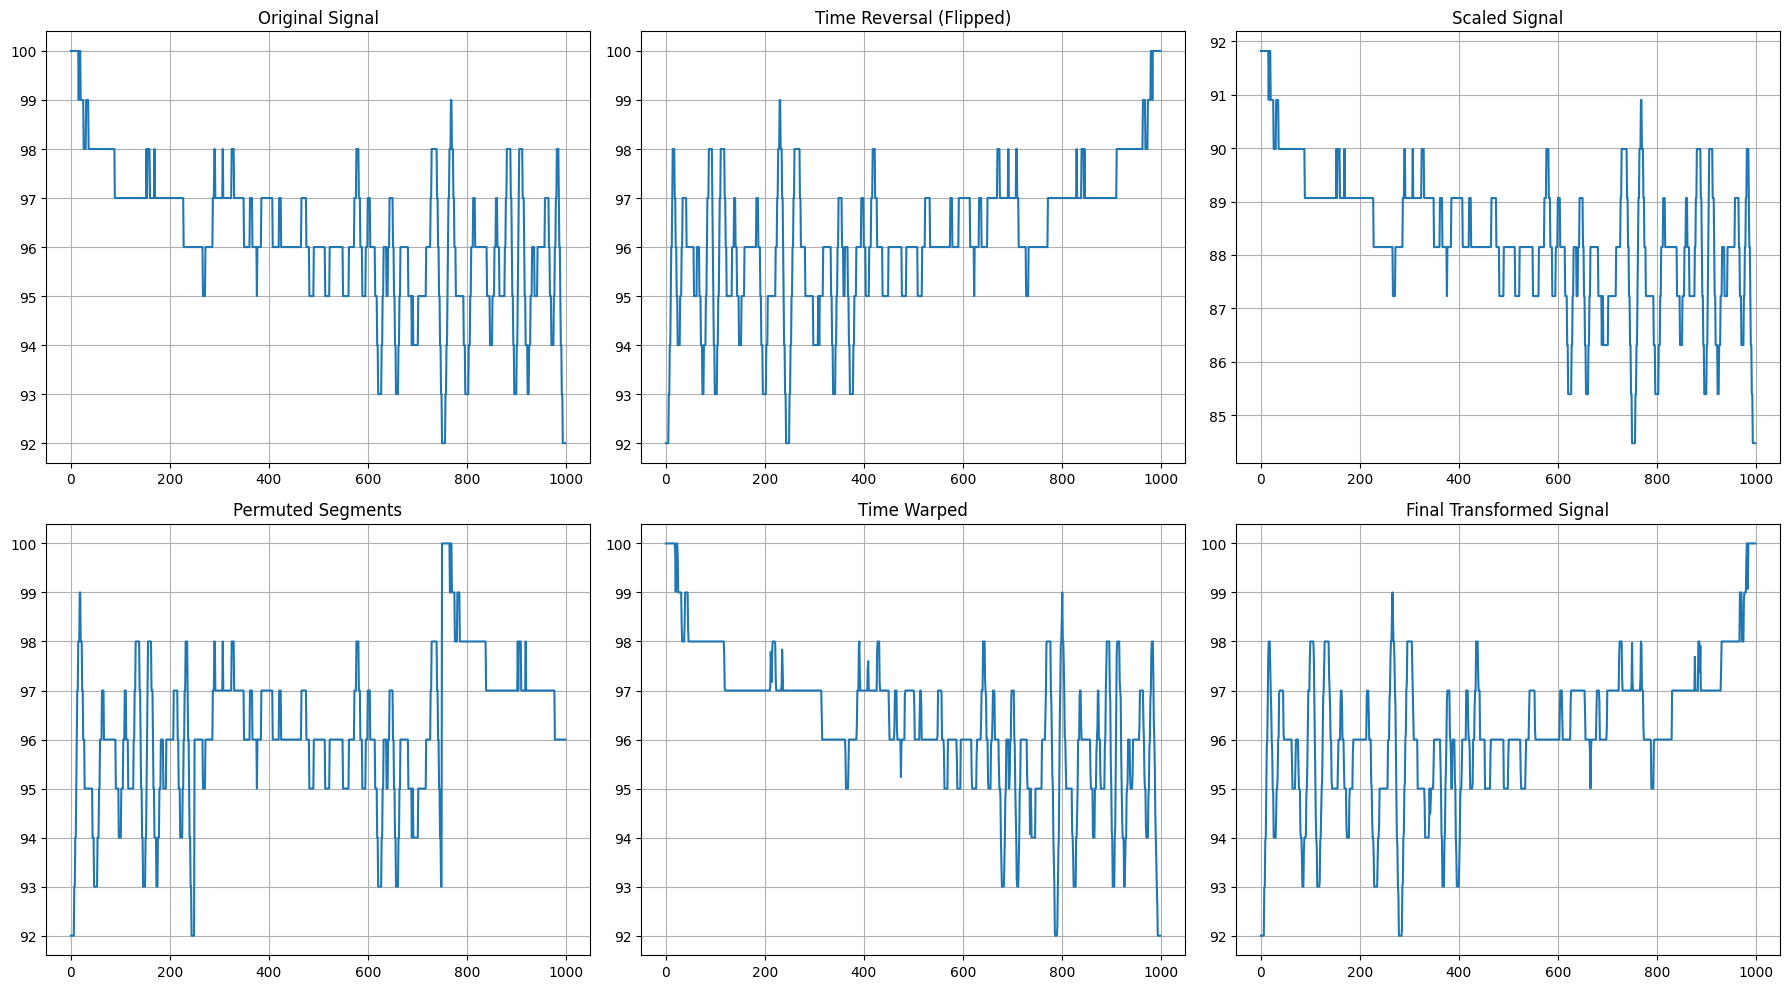

✅ Signal transformations are working!
Original signal range: [92.00, 100.00]
Transformed signal range: [92.00, 100.00]


In [23]:
# Visualize signal transformations to verify pretext tasks
import torch
from ssl_new_pipeline import (flip_time_series, scale_time_series, 
                             permute_time_series, time_warp_time_series,
                             generate_pretext_labels_and_transform)

# Take a sample signal for transformation demo
sample_signal = torch.tensor(truncated_signals[0], dtype=torch.float32).unsqueeze(0)  # Add batch dimension
print(f"Original signal shape: {sample_signal.shape}")

# Create SSL config for transformations
ssl_config = {
    'time_reversal': True,
    'scale': True, 
    'permutation': True,
    'time_warped': True,
    'positive_ratio': 0.5
}

# Generate transformations
x_transformed, labels = generate_pretext_labels_and_transform(sample_signal, ssl_config)
print(f"Labels for transformations: {labels[0]}")  # [time_reversal, scale, permutation, time_warped]

# Plot original vs transformed
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Original signal
axes[0, 0].plot(sample_signal[0, 0].numpy())
axes[0, 0].set_title('Original Signal')
axes[0, 0].grid(True)

# Individual transformations for visualization
test_signal = sample_signal.clone()

# Time reversal
flipped = flip_time_series(test_signal, 1)
axes[0, 1].plot(flipped[0, 0].numpy())
axes[0, 1].set_title('Time Reversal (Flipped)')
axes[0, 1].grid(True)

# Scaling
scaled = scale_time_series(test_signal, 1)
axes[0, 2].plot(scaled[0, 0].numpy())
axes[0, 2].set_title('Scaled Signal')
axes[0, 2].grid(True)

# Permutation
permuted = permute_time_series(test_signal, 1)
axes[1, 0].plot(permuted[0, 0].numpy())
axes[1, 0].set_title('Permuted Segments')
axes[1, 0].grid(True)

# Time warping
warped = time_warp_time_series(test_signal, 1)
axes[1, 1].plot(warped[0, 0].numpy())
axes[1, 1].set_title('Time Warped')
axes[1, 1].grid(True)

# Combined transformation (what actually gets fed to model)
axes[1, 2].plot(x_transformed[0, 0].numpy())
axes[1, 2].set_title('Final Transformed Signal')
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()

print("✅ Signal transformations are working!")
print(f"Original signal range: [{sample_signal.min():.2f}, {sample_signal.max():.2f}]")
print(f"Transformed signal range: [{x_transformed.min():.2f}, {x_transformed.max():.2f}]")

🚀 Starting Enhanced SSL Training with Progress Tracking
SSL Config: {'time_reversal': True, 'scale': True, 'permutation': True, 'time_warped': True, 'positive_ratio': 0.5}
Detected 1 channels
Target signal length: 1000
Number of signals: 9485
Active SSL tasks: ['time_reversal', 'scale', 'permutation', 'time_warped']
Training SSL model with tasks: ['time_reversal', 'scale', 'permutation', 'time_warped']
Dataset: 9485 signals, 1 channels, length 1000
Training: 20 epochs, batch size 16, lr 0.0001

Starting SSL Training...

Starting SSL Training...


SSL Epochs:   5%|▌         | 1/20 [01:17<24:25, 77.13s/epoch]

Epoch   1/20: Loss=0.6371 | Acc=0.5842 | time_reversal: 0.525 | scale: 0.795 | permutation: 0.501 | time_warped: 0.515 | Time=77.1s


SSL Epochs:  10%|█         | 2/20 [03:11<29:44, 99.13s/epoch]

Epoch   2/20: Loss=0.6103 | Acc=0.6105 | time_reversal: 0.617 | scale: 0.807 | permutation: 0.502 | time_warped: 0.516 | Time=114.5s


SSL Epochs:  15%|█▌        | 3/20 [04:44<27:19, 96.44s/epoch]

Epoch   3/20: Loss=0.5897 | Acc=0.6300 | time_reversal: 0.655 | scale: 0.825 | permutation: 0.506 | time_warped: 0.534 | Time=93.2s


SSL Epochs:  20%|██        | 4/20 [06:24<26:04, 97.75s/epoch]

Epoch   4/20: Loss=0.5082 | Acc=0.7037 | time_reversal: 0.679 | scale: 0.820 | permutation: 0.508 | time_warped: 0.807 | Time=99.8s


SSL Epochs:  25%|██▌       | 5/20 [08:29<26:53, 107.57s/epoch]

Epoch   5/20: Loss=0.4505 | Acc=0.7413 | time_reversal: 0.696 | scale: 0.818 | permutation: 0.520 | time_warped: 0.932 | Time=125.0s


SSL Epochs:  30%|███       | 6/20 [09:38<22:04, 94.58s/epoch] 

Epoch   6/20: Loss=0.4258 | Acc=0.7566 | time_reversal: 0.711 | scale: 0.828 | permutation: 0.522 | time_warped: 0.966 | Time=69.3s


SSL Epochs:  35%|███▌      | 7/20 [10:49<18:48, 86.80s/epoch]

Epoch   7/20: Loss=0.4107 | Acc=0.7626 | time_reversal: 0.717 | scale: 0.833 | permutation: 0.522 | time_warped: 0.978 | Time=70.8s


SSL Epochs:  40%|████      | 8/20 [12:04<16:36, 83.07s/epoch]

Epoch   8/20: Loss=0.4038 | Acc=0.7684 | time_reversal: 0.738 | scale: 0.828 | permutation: 0.523 | time_warped: 0.985 | Time=75.1s


SSL Epochs:  45%|████▌     | 9/20 [13:33<15:33, 84.83s/epoch]

Epoch   9/20: Loss=0.3988 | Acc=0.7733 | time_reversal: 0.748 | scale: 0.832 | permutation: 0.527 | time_warped: 0.986 | Time=88.7s


SSL Epochs:  50%|█████     | 10/20 [15:13<14:56, 89.61s/epoch]

Epoch  10/20: Loss=0.3923 | Acc=0.7770 | time_reversal: 0.755 | scale: 0.833 | permutation: 0.532 | time_warped: 0.987 | Time=100.3s


SSL Epochs:  55%|█████▌    | 11/20 [16:37<13:09, 87.67s/epoch]

Epoch  11/20: Loss=0.3898 | Acc=0.7753 | time_reversal: 0.752 | scale: 0.833 | permutation: 0.527 | time_warped: 0.988 | Time=83.3s


SSL Epochs:  60%|██████    | 12/20 [18:35<12:55, 96.92s/epoch]

Epoch  12/20: Loss=0.3823 | Acc=0.7842 | time_reversal: 0.766 | scale: 0.833 | permutation: 0.549 | time_warped: 0.988 | Time=118.1s


SSL Epochs:  65%|██████▌   | 13/20 [20:22<11:40, 100.08s/epoch]

Epoch  13/20: Loss=0.3795 | Acc=0.7879 | time_reversal: 0.772 | scale: 0.828 | permutation: 0.562 | time_warped: 0.989 | Time=107.3s


SSL Epochs:  70%|███████   | 14/20 [21:49<09:36, 96.09s/epoch] 

Epoch  14/20: Loss=0.3748 | Acc=0.7955 | time_reversal: 0.773 | scale: 0.837 | permutation: 0.579 | time_warped: 0.992 | Time=86.9s


SSL Epochs:  75%|███████▌  | 15/20 [24:18<09:20, 112.19s/epoch]

Epoch  15/20: Loss=0.3746 | Acc=0.7935 | time_reversal: 0.779 | scale: 0.835 | permutation: 0.570 | time_warped: 0.990 | Time=149.5s


SSL Epochs:  80%|████████  | 16/20 [26:56<08:22, 125.73s/epoch]

Epoch  16/20: Loss=0.3661 | Acc=0.7995 | time_reversal: 0.778 | scale: 0.837 | permutation: 0.587 | time_warped: 0.995 | Time=157.2s


SSL Epochs:  85%|████████▌ | 17/20 [28:28<05:47, 115.69s/epoch]

Epoch  17/20: Loss=0.3679 | Acc=0.8015 | time_reversal: 0.789 | scale: 0.834 | permutation: 0.594 | time_warped: 0.989 | Time=92.4s


SSL Epochs:  90%|█████████ | 18/20 [30:53<04:09, 124.62s/epoch]

Epoch  18/20: Loss=0.3606 | Acc=0.8050 | time_reversal: 0.781 | scale: 0.844 | permutation: 0.603 | time_warped: 0.992 | Time=145.4s


SSL Epochs:  95%|█████████▌| 19/20 [34:00<02:23, 143.35s/epoch]

Epoch  19/20: Loss=0.3562 | Acc=0.8086 | time_reversal: 0.786 | scale: 0.842 | permutation: 0.614 | time_warped: 0.992 | Time=187.0s


SSL Epochs: 100%|██████████| 20/20 [35:15<00:00, 105.76s/epoch]



Epoch  20/20: Loss=0.3562 | Acc=0.8077 | time_reversal: 0.791 | scale: 0.840 | permutation: 0.607 | time_warped: 0.993 | Time=74.3s

SSL Training Complete! Total time: 2115.1s
Final metrics: Loss=0.3562, Acc=0.8077


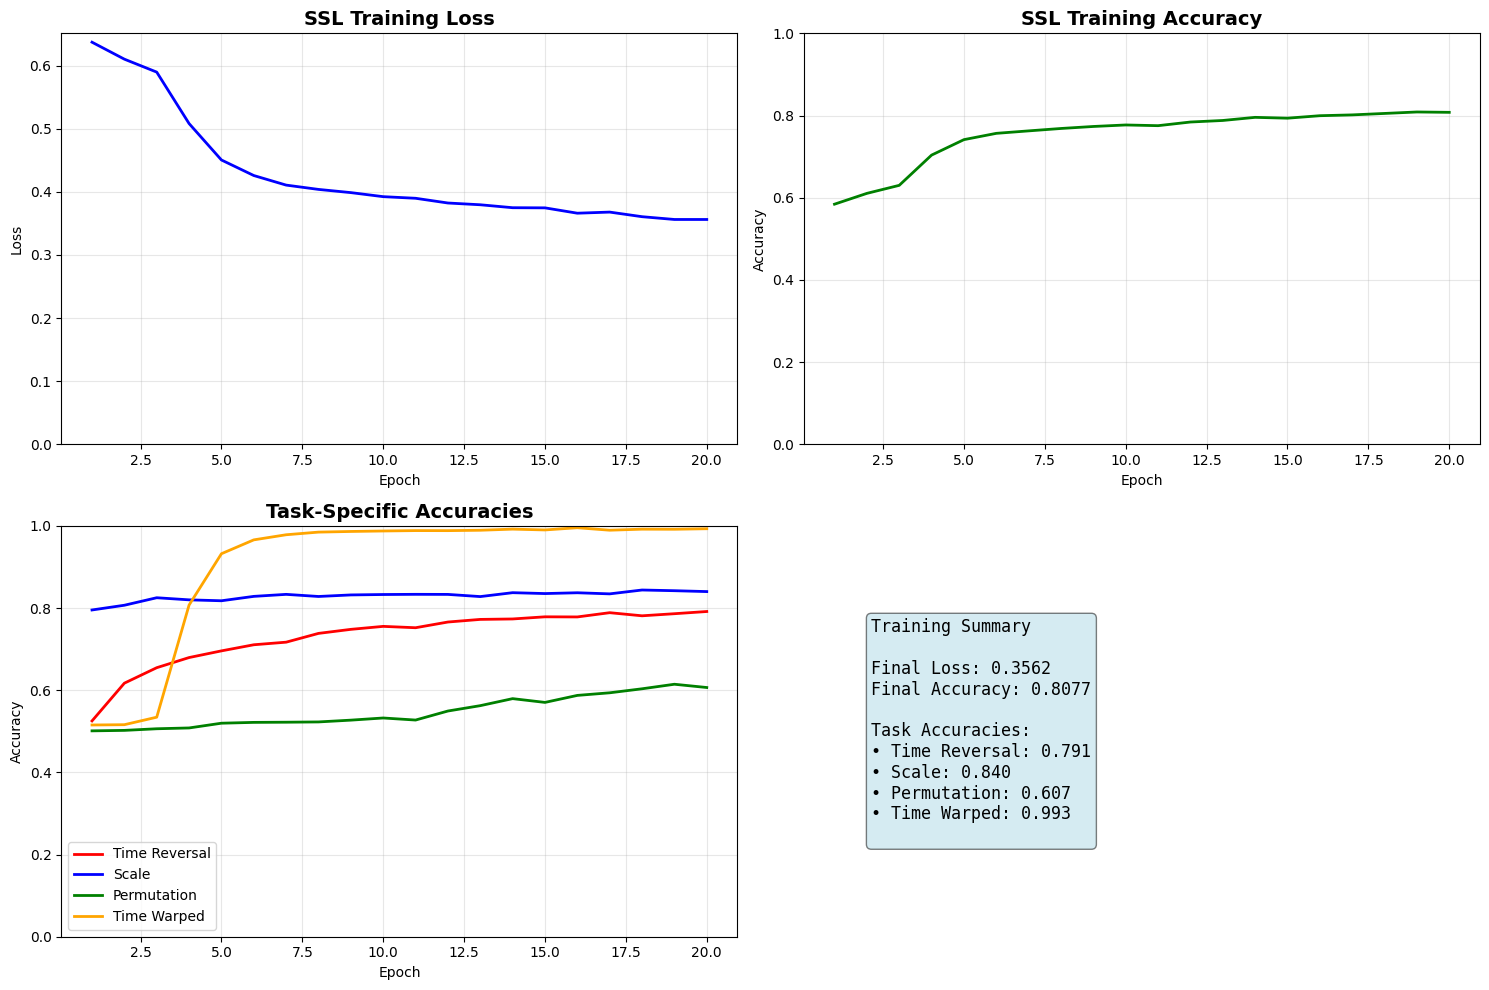

Training progress plot saved as 'ssl_training_progress.png'
SSL model saved to: spo2_ssl_model_enhanced_20250905_201711.pth
Training completed on: 2025-09-05 20:17:11


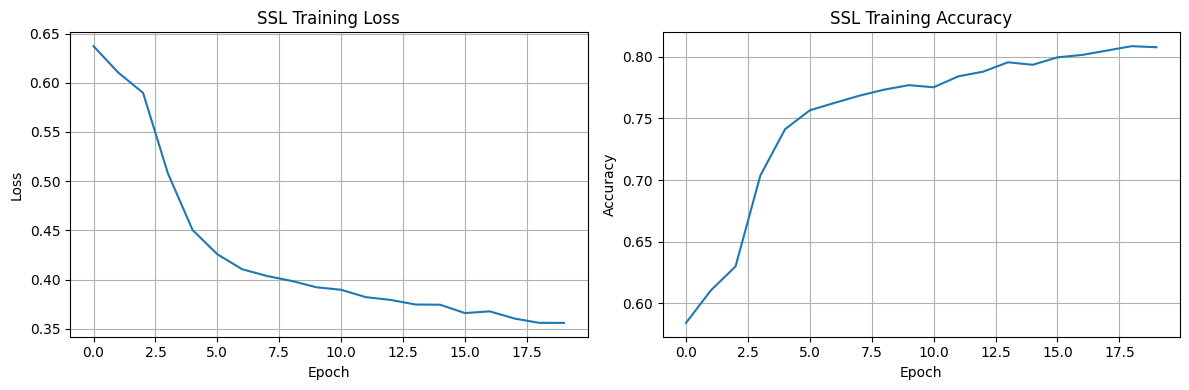


✅ SSL training completed! Model saved to: spo2_ssl_model_enhanced_20250905_201711.pth
🎯 Check the training progress plots above!


In [24]:
# Train SSL model on SpO2 signals with enhanced progress tracking
print("🚀 Starting Enhanced SSL Training with Progress Tracking")
print("="*60)

# Reload the updated ssl_utils module
import importlib
importlib.reload(sys.modules['ssl_utils'])
from ssl_utils import train_ssl

# Train with enhanced logging and progress bars
model_path = train_ssl(
    signals=truncated_signals,
    signal_length=min_length,
    epochs=20,  # Reduced for faster demo
    learning_rate=1e-4,
    batch_size=16,  # Smaller batch size for limited data
    model_save_path="spo2_ssl_model_enhanced.pth"
)

print(f"\n✅ SSL training completed! Model saved to: {model_path}")
print("🎯 Check the training progress plots above!")

🎯 Starting Downstream Classification Task
AHI data loaded: 370 patients
Sample data:
       ID   AHI   ISI
0  GW4001  25.8  15.0
1  GW4002  18.6   6.0
2  GW4003  71.7  11.0
3  GW4004   6.1  15.0
4  GW4005  50.1   5.0

Target distribution:
AHI < 15: 136 patients
AHI >= 15: 234 patients

Matched 8813 signal segments with AHI labels
Target distribution in matched data:
AHI < 15: 3305 segments
AHI >= 15: 5508 segments
Minimum signal length for downstream: 1000
Prepared 8813 signals for downstream task
Signal shape: (1, 1000)

Matched 8813 signal segments with AHI labels
Target distribution in matched data:
AHI < 15: 3305 segments
AHI >= 15: 5508 segments
Minimum signal length for downstream: 1000
Prepared 8813 signals for downstream task
Signal shape: (1, 1000)


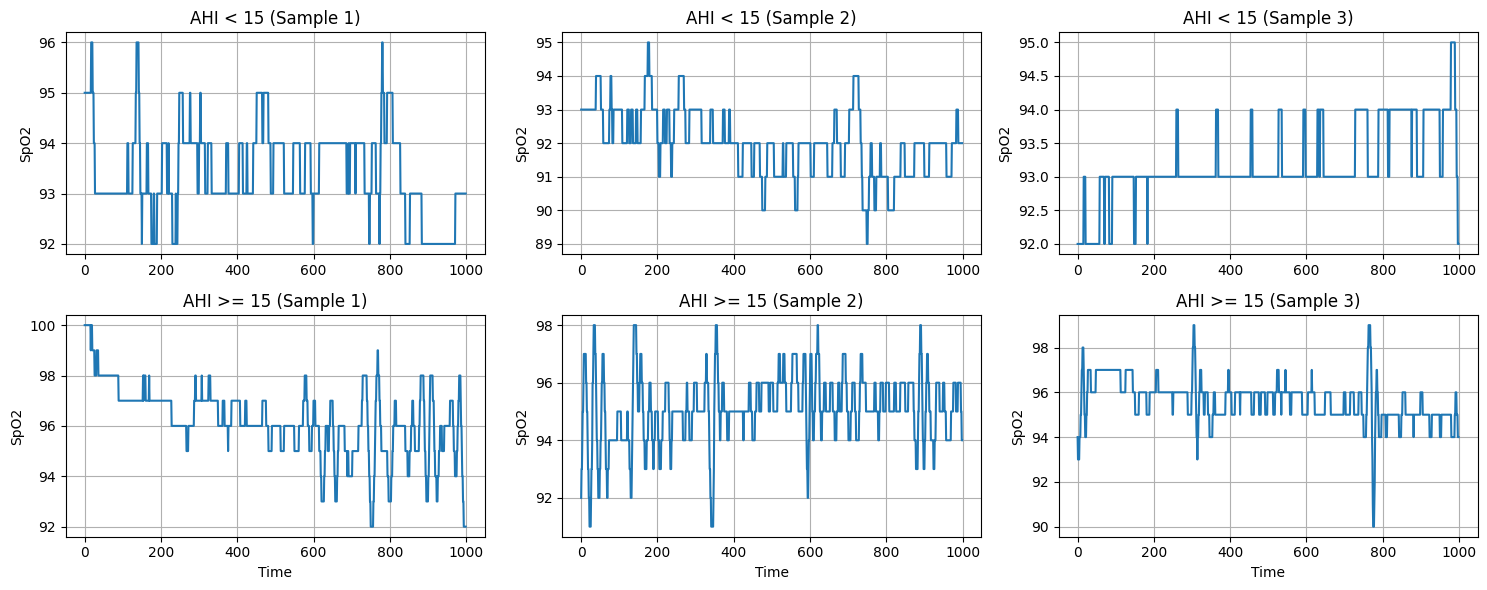

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split

print("🎯 Starting Downstream Classification Task")
print("="*60)

# Load AHI data
ahi_df = pd.read_csv('patient_ahi_isi.csv')
print(f"AHI data loaded: {len(ahi_df)} patients")
print("Sample data:")
print(ahi_df.head())

# Create binary target: AHI >= 15
ahi_df['AHI_binary'] = (ahi_df['AHI'] >= 15).astype(int)
print(f"\nTarget distribution:")
print(f"AHI < 15: {(ahi_df['AHI_binary'] == 0).sum()} patients")
print(f"AHI >= 15: {(ahi_df['AHI_binary'] == 1).sum()} patients")

# Match signals with AHI labels
downstream_signals = []
downstream_targets = []
matched_patients = []

for signal, patient_name in new_df_list:
    # Extract patient ID from segment name (e.g., "GW4001_seg0" -> "GW4001")
    if '_seg' in patient_name:
        patient_id = patient_name.split('_seg')[0]
    else:
        patient_id = patient_name
    
    # Check if this patient exists in AHI data
    patient_row = ahi_df[ahi_df['ID'] == patient_id]
    if not patient_row.empty:
        # Filter signals with <=50% zeros
        zero_percentage = np.sum(signal == 0) / len(signal)
        if zero_percentage <= 0.5:
            # Apply same interpolation as training data
            filtered_signal = filter_and_interpolate(signal)
            downstream_signals.append(filtered_signal)
            downstream_targets.append(patient_row['AHI_binary'].iloc[0])
            matched_patients.append(patient_id)

print(f"\nMatched {len(downstream_signals)} signal segments with AHI labels")
print(f"Target distribution in matched data:")
print(f"AHI < 15: {np.sum(np.array(downstream_targets) == 0)} segments")
print(f"AHI >= 15: {np.sum(np.array(downstream_targets) == 1)} segments")

# Prepare signals (same preprocessing as SSL training)
min_downstream_length = min(len(signal) for signal in downstream_signals)
print(f"Minimum signal length for downstream: {min_downstream_length}")

downstream_processed = []
for signal in downstream_signals:
    truncated = signal[:min_downstream_length]
    downstream_processed.append(truncated.reshape(1, -1))

print(f"Prepared {len(downstream_processed)} signals for downstream task")
print(f"Signal shape: {downstream_processed[0].shape}")

# Visualize some examples
plt.figure(figsize=(15, 6))
class_0_indices = [i for i, target in enumerate(downstream_targets) if target == 0]
class_1_indices = [i for i, target in enumerate(downstream_targets) if target == 1]

for i in range(3):
    plt.subplot(2, 3, i+1)
    if i < len(class_0_indices):
        plt.plot(downstream_processed[class_0_indices[i]][0])
        plt.title(f'AHI < 15 (Sample {i+1})')
    plt.grid(True)
    plt.ylabel('SpO2')

for i in range(3):
    plt.subplot(2, 3, i+4)
    if i < len(class_1_indices):
        plt.plot(downstream_processed[class_1_indices[i]][0])
        plt.title(f'AHI >= 15 (Sample {i+1})')
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('SpO2')

plt.tight_layout()
plt.show()

🚀 Testing Downstream Classification with SSL Features
Loading SSL model from: spo2_ssl_model_enhanced_20250905_201711.pth
Loaded model with 1 channels and tasks: ['time_reversal', 'scale', 'permutation', 'time_warped']
Dataset: 8813 signals, target length: 1000

Starting downstream fine-tuning...
Train: 7050 samples, Val: 1763 samples
Training: 50 epochs, lr 0.001

Starting downstream fine-tuning...
Train: 7050 samples, Val: 1763 samples
Training: 50 epochs, lr 0.001


Fine-tuning:   2%|▏         | 1/50 [00:27<22:06, 27.08s/epoch]

Epoch   1/50: Train Loss=0.5953 | Train Acc=0.6670 | Val Loss=0.5082 | Val Acc=0.7149 | Time=27.1s


Fine-tuning:   4%|▍         | 2/50 [00:52<21:06, 26.39s/epoch]

Epoch   2/50: Train Loss=0.5783 | Train Acc=0.6818 | Val Loss=0.5764 | Val Acc=0.6323 | Time=25.9s


Fine-tuning:   6%|▌         | 3/50 [01:16<19:30, 24.91s/epoch]

Epoch   3/50: Train Loss=0.5766 | Train Acc=0.6808 | Val Loss=0.5673 | Val Acc=0.6441 | Time=23.2s


Fine-tuning:   8%|▊         | 4/50 [01:33<16:51, 21.98s/epoch]

Epoch   4/50: Train Loss=0.5734 | Train Acc=0.6821 | Val Loss=0.5196 | Val Acc=0.7021 | Time=17.5s


Fine-tuning:  10%|█         | 5/50 [02:08<19:55, 26.58s/epoch]

Epoch   5/50: Train Loss=0.5742 | Train Acc=0.6813 | Val Loss=0.5239 | Val Acc=0.6948 | Time=34.7s


Fine-tuning:  12%|█▏        | 6/50 [04:08<42:52, 58.46s/epoch]

Epoch   6/50: Train Loss=0.5661 | Train Acc=0.6954 | Val Loss=0.4995 | Val Acc=0.7213 | Time=120.4s


Fine-tuning:  14%|█▍        | 7/50 [04:59<40:04, 55.92s/epoch]

Epoch   7/50: Train Loss=0.5664 | Train Acc=0.6978 | Val Loss=0.5001 | Val Acc=0.7202 | Time=50.7s


Fine-tuning:  16%|█▌        | 8/50 [05:34<34:34, 49.39s/epoch]

Epoch   8/50: Train Loss=0.5656 | Train Acc=0.6959 | Val Loss=0.5513 | Val Acc=0.6931 | Time=35.4s


Fine-tuning:  18%|█▊        | 9/50 [06:05<29:41, 43.45s/epoch]

Epoch   9/50: Train Loss=0.5628 | Train Acc=0.6979 | Val Loss=0.5052 | Val Acc=0.7095 | Time=30.4s


Fine-tuning:  20%|██        | 10/50 [06:28<24:54, 37.35s/epoch]

Epoch  10/50: Train Loss=0.5618 | Train Acc=0.6886 | Val Loss=0.4973 | Val Acc=0.7258 | Time=23.7s


Fine-tuning:  22%|██▏       | 11/50 [07:02<23:35, 36.30s/epoch]

Epoch  11/50: Train Loss=0.5631 | Train Acc=0.6928 | Val Loss=0.4868 | Val Acc=0.7382 | Time=33.9s


Fine-tuning:  24%|██▍       | 12/50 [07:28<20:58, 33.11s/epoch]

Epoch  12/50: Train Loss=0.5577 | Train Acc=0.6967 | Val Loss=0.5118 | Val Acc=0.7190 | Time=25.8s


Fine-tuning:  26%|██▌       | 13/50 [08:18<23:36, 38.28s/epoch]

Epoch  13/50: Train Loss=0.5635 | Train Acc=0.6958 | Val Loss=0.5720 | Val Acc=0.6689 | Time=50.2s


Fine-tuning:  28%|██▊       | 14/50 [08:52<22:10, 36.95s/epoch]

Epoch  14/50: Train Loss=0.5608 | Train Acc=0.6969 | Val Loss=0.4827 | Val Acc=0.7309 | Time=33.9s


Fine-tuning:  30%|███       | 15/50 [09:29<21:31, 36.90s/epoch]

Epoch  15/50: Train Loss=0.5574 | Train Acc=0.7030 | Val Loss=0.5005 | Val Acc=0.7179 | Time=36.8s


Fine-tuning:  32%|███▏      | 16/50 [09:54<18:53, 33.35s/epoch]

Epoch  16/50: Train Loss=0.5608 | Train Acc=0.6939 | Val Loss=0.4823 | Val Acc=0.7325 | Time=25.1s


Fine-tuning:  34%|███▍      | 17/50 [10:24<17:44, 32.27s/epoch]

Epoch  17/50: Train Loss=0.5503 | Train Acc=0.7016 | Val Loss=0.4914 | Val Acc=0.7123 | Time=29.7s


Fine-tuning:  36%|███▌      | 18/50 [10:56<17:09, 32.18s/epoch]

Epoch  18/50: Train Loss=0.5546 | Train Acc=0.6978 | Val Loss=0.4880 | Val Acc=0.7258 | Time=32.0s


Fine-tuning:  38%|███▊      | 19/50 [11:33<17:21, 33.60s/epoch]

Epoch  19/50: Train Loss=0.5486 | Train Acc=0.7061 | Val Loss=0.4851 | Val Acc=0.7286 | Time=36.9s


Fine-tuning:  40%|████      | 20/50 [12:27<19:54, 39.82s/epoch]

Epoch  20/50: Train Loss=0.5524 | Train Acc=0.6991 | Val Loss=0.5294 | Val Acc=0.6931 | Time=54.3s


Fine-tuning:  42%|████▏     | 21/50 [13:17<20:43, 42.89s/epoch]

Epoch  21/50: Train Loss=0.5573 | Train Acc=0.6980 | Val Loss=0.4926 | Val Acc=0.7275 | Time=50.0s


Fine-tuning:  44%|████▍     | 22/50 [13:35<16:31, 35.43s/epoch]

Epoch  22/50: Train Loss=0.5521 | Train Acc=0.7058 | Val Loss=0.4784 | Val Acc=0.7449 | Time=18.0s


Fine-tuning:  46%|████▌     | 23/50 [14:10<15:54, 35.35s/epoch]

Epoch  23/50: Train Loss=0.5483 | Train Acc=0.7032 | Val Loss=0.4890 | Val Acc=0.7325 | Time=35.2s


Fine-tuning:  48%|████▊     | 24/50 [14:35<13:56, 32.19s/epoch]

Epoch  24/50: Train Loss=0.5580 | Train Acc=0.6958 | Val Loss=0.5076 | Val Acc=0.7100 | Time=24.8s


Fine-tuning:  50%|█████     | 25/50 [15:16<14:30, 34.81s/epoch]

Epoch  25/50: Train Loss=0.5536 | Train Acc=0.6983 | Val Loss=0.4763 | Val Acc=0.7337 | Time=40.9s


Fine-tuning:  52%|█████▏    | 26/50 [15:32<11:38, 29.11s/epoch]

Epoch  26/50: Train Loss=0.5480 | Train Acc=0.7046 | Val Loss=0.4756 | Val Acc=0.7370 | Time=15.8s


Fine-tuning:  54%|█████▍    | 27/50 [16:04<11:32, 30.11s/epoch]

Epoch  27/50: Train Loss=0.5542 | Train Acc=0.6950 | Val Loss=0.4691 | Val Acc=0.7348 | Time=32.4s


Fine-tuning:  56%|█████▌    | 28/50 [16:24<09:51, 26.87s/epoch]

Epoch  28/50: Train Loss=0.5525 | Train Acc=0.7006 | Val Loss=0.4888 | Val Acc=0.7314 | Time=19.3s


Fine-tuning:  58%|█████▊    | 29/50 [16:53<09:42, 27.72s/epoch]

Epoch  29/50: Train Loss=0.5462 | Train Acc=0.7051 | Val Loss=0.4877 | Val Acc=0.7247 | Time=29.7s


Fine-tuning:  60%|██████    | 30/50 [17:26<09:46, 29.33s/epoch]

Epoch  30/50: Train Loss=0.5509 | Train Acc=0.6966 | Val Loss=0.4738 | Val Acc=0.7370 | Time=33.1s


Fine-tuning:  62%|██████▏   | 31/50 [17:53<09:03, 28.58s/epoch]

Epoch  31/50: Train Loss=0.5486 | Train Acc=0.7026 | Val Loss=0.4729 | Val Acc=0.7410 | Time=26.8s


Fine-tuning:  64%|██████▍   | 32/50 [18:11<07:37, 25.42s/epoch]

Epoch  32/50: Train Loss=0.5488 | Train Acc=0.7048 | Val Loss=0.4836 | Val Acc=0.7342 | Time=18.0s


Fine-tuning:  66%|██████▌   | 33/50 [18:31<06:45, 23.85s/epoch]

Epoch  33/50: Train Loss=0.5476 | Train Acc=0.7051 | Val Loss=0.4733 | Val Acc=0.7387 | Time=20.2s


Fine-tuning:  68%|██████▊   | 34/50 [18:59<06:41, 25.07s/epoch]

Epoch  34/50: Train Loss=0.5481 | Train Acc=0.7065 | Val Loss=0.4685 | Val Acc=0.7466 | Time=27.9s


Fine-tuning:  70%|███████   | 35/50 [19:21<06:01, 24.08s/epoch]

Epoch  35/50: Train Loss=0.5490 | Train Acc=0.7065 | Val Loss=0.4781 | Val Acc=0.7337 | Time=21.8s


Fine-tuning:  72%|███████▏  | 36/50 [19:37<05:04, 21.76s/epoch]

Epoch  36/50: Train Loss=0.5468 | Train Acc=0.6979 | Val Loss=0.4950 | Val Acc=0.7224 | Time=16.3s


Fine-tuning:  74%|███████▍  | 37/50 [19:59<04:40, 21.56s/epoch]

Epoch  37/50: Train Loss=0.5464 | Train Acc=0.7080 | Val Loss=0.4837 | Val Acc=0.7320 | Time=21.1s


Fine-tuning:  76%|███████▌  | 38/50 [20:20<04:19, 21.65s/epoch]

Epoch  38/50: Train Loss=0.5442 | Train Acc=0.7029 | Val Loss=0.4750 | Val Acc=0.7466 | Time=21.9s


Fine-tuning:  78%|███████▊  | 39/50 [20:48<04:17, 23.39s/epoch]

Epoch  39/50: Train Loss=0.5411 | Train Acc=0.7034 | Val Loss=0.5004 | Val Acc=0.6982 | Time=27.4s


Fine-tuning:  80%|████████  | 40/50 [21:40<05:21, 32.13s/epoch]

Epoch  40/50: Train Loss=0.5447 | Train Acc=0.7014 | Val Loss=0.4935 | Val Acc=0.7235 | Time=52.5s


Fine-tuning:  82%|████████▏ | 41/50 [22:24<05:19, 35.51s/epoch]

Epoch  41/50: Train Loss=0.5467 | Train Acc=0.7005 | Val Loss=0.4869 | Val Acc=0.7280 | Time=43.4s


Fine-tuning:  84%|████████▍ | 42/50 [23:26<05:47, 43.43s/epoch]

Epoch  42/50: Train Loss=0.5459 | Train Acc=0.7090 | Val Loss=0.4719 | Val Acc=0.7455 | Time=61.9s


Fine-tuning:  86%|████████▌ | 43/50 [24:08<05:01, 43.01s/epoch]

Epoch  43/50: Train Loss=0.5474 | Train Acc=0.7066 | Val Loss=0.4882 | Val Acc=0.7241 | Time=42.0s


Fine-tuning:  88%|████████▊ | 44/50 [24:59<04:32, 45.40s/epoch]

Epoch  44/50: Train Loss=0.5504 | Train Acc=0.7080 | Val Loss=0.4624 | Val Acc=0.7511 | Time=51.0s


Fine-tuning:  90%|█████████ | 45/50 [25:19<03:09, 37.92s/epoch]

Epoch  45/50: Train Loss=0.5478 | Train Acc=0.7000 | Val Loss=0.5052 | Val Acc=0.7168 | Time=20.5s


Fine-tuning:  92%|█████████▏| 46/50 [25:37<02:07, 31.97s/epoch]

Epoch  46/50: Train Loss=0.5466 | Train Acc=0.7040 | Val Loss=0.4762 | Val Acc=0.7387 | Time=18.1s


Fine-tuning:  94%|█████████▍| 47/50 [26:14<01:40, 33.41s/epoch]

Epoch  47/50: Train Loss=0.5448 | Train Acc=0.7092 | Val Loss=0.4696 | Val Acc=0.7348 | Time=36.7s


Fine-tuning:  96%|█████████▌| 48/50 [26:39<01:01, 30.85s/epoch]

Epoch  48/50: Train Loss=0.5429 | Train Acc=0.7055 | Val Loss=0.4653 | Val Acc=0.7466 | Time=24.9s


Fine-tuning:  98%|█████████▊| 49/50 [27:05<00:29, 29.48s/epoch]

Epoch  49/50: Train Loss=0.5493 | Train Acc=0.7114 | Val Loss=0.4865 | Val Acc=0.7269 | Time=26.3s


Fine-tuning: 100%|██████████| 50/50 [27:33<00:00, 33.08s/epoch]



Epoch  50/50: Train Loss=0.5461 | Train Acc=0.7111 | Val Loss=0.4859 | Val Acc=0.7382 | Time=28.3s

Fine-tuning Complete! Total time: 1654.0s

=== Final Results ===
Accuracy: 0.7362
F1 Score: 0.8090
AUC: 0.7937

=== Final Results ===
Accuracy: 0.7362
F1 Score: 0.8090
AUC: 0.7937


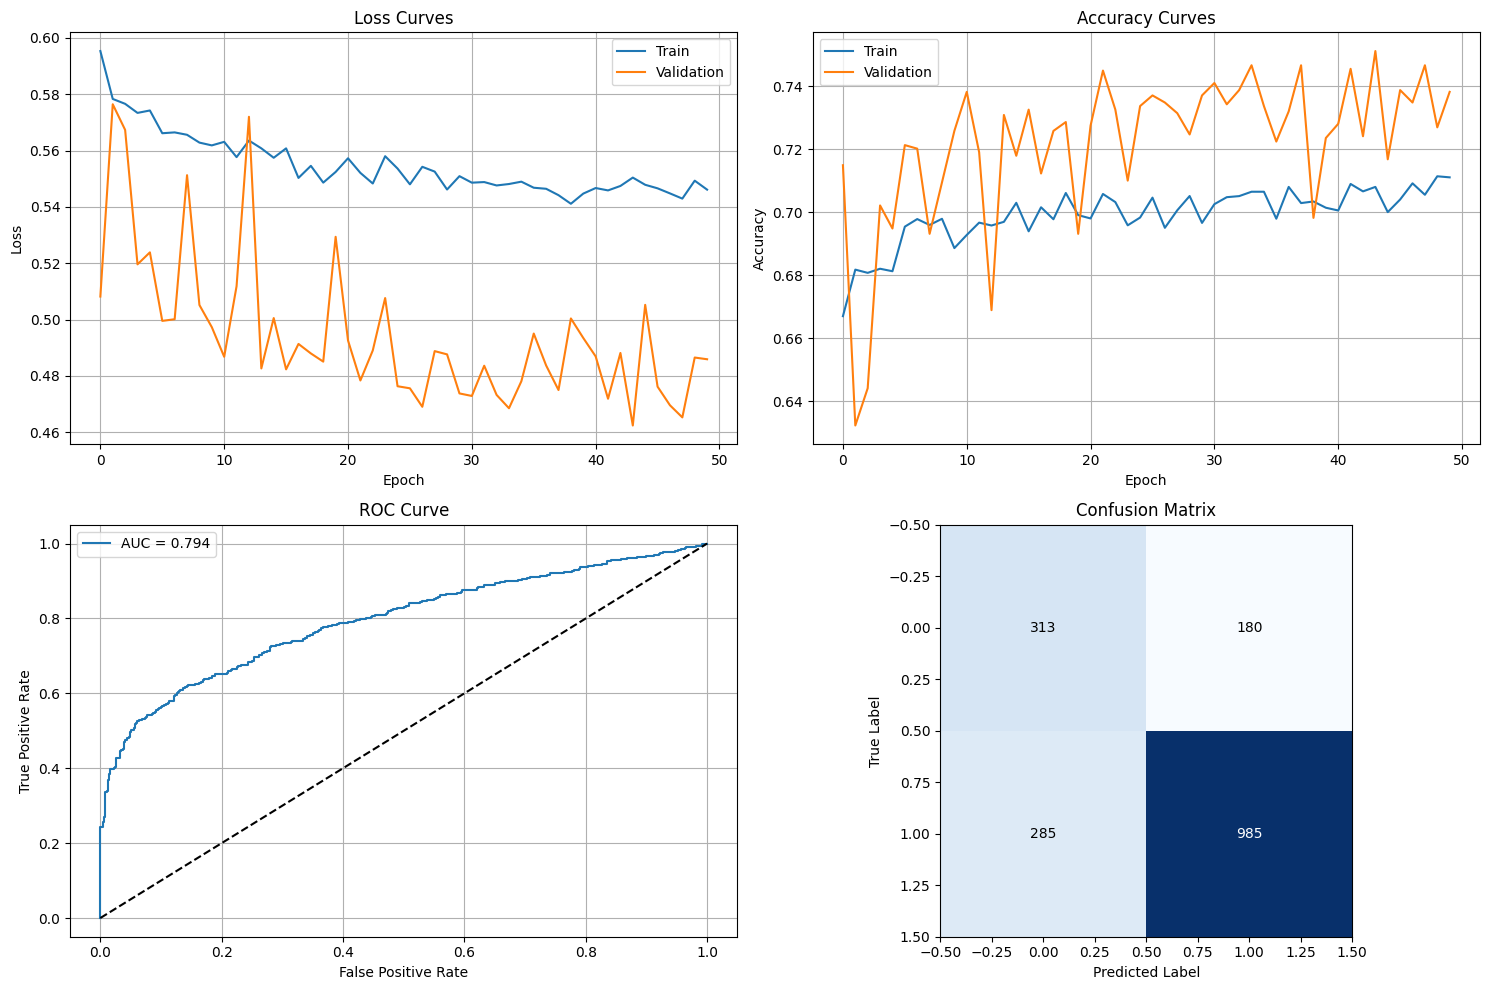

Results saved to: ahi_classification_results.json

✅ Downstream classification completed!
📊 Results saved and plots generated
🎯 Final Performance:
   • Accuracy: 0.7362
   • F1 Score: 0.8090
   • AUC: 0.7937


In [28]:
# Test downstream task using SSL pretrained model
print("🚀 Testing Downstream Classification with SSL Features")
print("="*60)

# Import test_ssl function
from ssl_utils import test_ssl

# Use the test_ssl function from ssl_utils
results = test_ssl(
    test_signals=downstream_processed,
    signal_length=min_downstream_length,
    targets=downstream_targets,
    model_path="spo2_ssl_model_enhanced_20250905_201711.pth",
    epochs=50,
    learning_rate=1e-3,
    batch_size=16,
    results_save_path="ahi_classification_results.json"
)

print("\n✅ Downstream classification completed!")
print(f"📊 Results saved and plots generated")
print(f"🎯 Final Performance:")
print(f"   • Accuracy: {results['accuracy']:.4f}")
print(f"   • F1 Score: {results['f1_score']:.4f}")
print(f"   • AUC: {results['auc']:.4f}")

In [1]:
# Architecture Analysis: SSL Feature Extractor + Downstream Classifier
print("🏗️ SSL Model Architecture Analysis")
print("="*80)

# Load the trained model to inspect architecture
import torch
from ssl_new_pipeline import ResNetSSL, DownstreamClassifier

# Load the SSL model
checkpoint = torch.load("spo2_ssl_model_enhanced_20250905_201711.pth", map_location='cpu')
model_config = checkpoint['model_config']

ssl_model = ResNetSSL(
    in_channels=model_config['in_channels'],
    n_classes_per_task=2,
    tasks=model_config['tasks']
)
ssl_model.load_state_dict(checkpoint['model_state_dict'])

print(f"Model config: {model_config}")
print(f"Signal length used in training: {model_config['signal_length']}")

# Create a sample input to trace through the network
sample_input = torch.randn(1, 1, 1000)  # (batch_size, channels, sequence_length)
print(f"\nInput shape: {sample_input.shape}")

print("\n" + "="*80)
print("🔍 FROZEN FEATURE EXTRACTOR ARCHITECTURE (SSL Model)")
print("="*80)

# Trace through each layer of the feature extractor
x = sample_input
layer_outputs = []

# Initial Conv1d + BatchNorm + ReLU
conv1 = ssl_model.feature_extractor[0]  # Conv1d(1, 64, kernel=7, stride=2, padding=3)
bn1 = ssl_model.feature_extractor[1]    # BatchNorm1d(64)
relu1 = ssl_model.feature_extractor[2]  # ReLU

x = conv1(x)
print(f"1. Conv1d(1→64, k=7, s=2, p=3):  {sample_input.shape} → {x.shape}")
x = bn1(x)
print(f"2. BatchNorm1d(64):              {x.shape} → {x.shape}")
x = relu1(x)
print(f"3. ReLU:                         {x.shape} → {x.shape}")

# ResNet layers
layer_names = ['Layer1 (64→64)', 'Layer2 (64→128)', 'Layer3 (128→256)', 'Layer4 (256→512)']
for i, layer_name in enumerate(layer_names):
    layer = ssl_model.feature_extractor[3 + i]  # ResNet layers start at index 3
    x_before = x.shape
    x = layer(x)
    print(f"4.{i+1} {layer_name:20}: {x_before} → {x.shape}")

# Adaptive Average Pooling
adaptive_pool = ssl_model.feature_extractor[-1]  # AdaptiveAvgPool1d(1)
x_before = x.shape
x = adaptive_pool(x)
print(f"5. AdaptiveAvgPool1d(1):         {x_before} → {x.shape}")

# Flatten for downstream classifier
features = x.squeeze(-1)  # Remove the last dimension
print(f"6. Squeeze(-1):                  {x.shape} → {features.shape}")

print(f"\n📦 Final SSL Features: {features.shape} (512-dimensional feature vector)")

print("\n" + "="*80)
print("🎯 DOWNSTREAM CLASSIFIER ARCHITECTURE (Trainable)")
print("="*80)

# Create downstream classifier
downstream_model = DownstreamClassifier(ssl_model.feature_extractor, n_classes=2)

# Trace through downstream classifier
print("Frozen Feature Extractor:")
print(f"  Input:  {sample_input.shape}")
print(f"  Output: {features.shape} (512-dim features)")
print("  Status: FROZEN ❄️ (gradients disabled)")

print("\nTrainable Classifier Head:")
classifier_layers = list(downstream_model.classifier.children())

x_clf = features
for i, layer in enumerate(classifier_layers):
    x_before = x_clf.shape
    x_clf = layer(x_clf)
    layer_type = type(layer).__name__
    
    if hasattr(layer, 'in_features') and hasattr(layer, 'out_features'):
        layer_desc = f"{layer_type}({layer.in_features}→{layer.out_features})"
    elif hasattr(layer, 'p'):
        layer_desc = f"{layer_type}(p={layer.p})"
    else:
        layer_desc = layer_type
    
    print(f"  {i+1}. {layer_desc:25}: {x_before} → {x_clf.shape}")

print(f"\n🎯 Final Output: {x_clf.shape} (2 classes: AHI<15 vs AHI≥15)")

print("\n" + "="*80)
print("📊 PARAMETER COUNT ANALYSIS")
print("="*80)

# Count parameters
total_params = sum(p.numel() for p in ssl_model.parameters())
frozen_params = sum(p.numel() for p in ssl_model.feature_extractor.parameters())
trainable_params = sum(p.numel() for p in downstream_model.classifier.parameters() if p.requires_grad)

print(f"SSL Model (Total):     {total_params:,} parameters")
print(f"Feature Extractor:     {frozen_params:,} parameters (FROZEN ❄️)")
print(f"Classifier Head:       {trainable_params:,} parameters (TRAINABLE 🔥)")
print(f"Training Efficiency:   Only {trainable_params/total_params*100:.1f}% of parameters are updated!")

print("\n" + "="*80)
print("🔄 DATA FLOW SUMMARY")
print("="*80)

print("1. SpO2 Signal Input:     (batch, 1, 1000)")
print("2. SSL Feature Extraction: (batch, 1, 1000) → (batch, 512)")
print("3. Classification:         (batch, 512) → (batch, 2)")
print("4. Softmax Output:         Probabilities for [AHI<15, AHI≥15]")



🏗️ SSL Model Architecture Analysis
Model config: {'in_channels': 1, 'tasks': ['time_reversal', 'scale', 'permutation', 'time_warped'], 'signal_length': 1000}
Signal length used in training: 1000

Input shape: torch.Size([1, 1, 1000])

🔍 FROZEN FEATURE EXTRACTOR ARCHITECTURE (SSL Model)
1. Conv1d(1→64, k=7, s=2, p=3):  torch.Size([1, 1, 1000]) → torch.Size([1, 64, 500])
2. BatchNorm1d(64):              torch.Size([1, 64, 500]) → torch.Size([1, 64, 500])
3. ReLU:                         torch.Size([1, 64, 500]) → torch.Size([1, 64, 500])
4.1 Layer1 (64→64)      : torch.Size([1, 64, 500]) → torch.Size([1, 64, 500])
4.2 Layer2 (64→128)     : torch.Size([1, 64, 500]) → torch.Size([1, 128, 250])
4.3 Layer3 (128→256)    : torch.Size([1, 128, 250]) → torch.Size([1, 256, 125])
4.4 Layer4 (256→512)    : torch.Size([1, 256, 125]) → torch.Size([1, 512, 63])
5. AdaptiveAvgPool1d(1):         torch.Size([1, 512, 63]) → torch.Size([1, 512, 1])
6. Squeeze(-1):                  torch.Size([1, 512, 1]) →